In [19]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import new_interf
from datetime import datetime, timedelta
import scipy.optimize
import astropy.constants as c
import astropy.units as u

In [20]:
ugradio.timing.lst

<function ugradio.timing.lst(jd=None, lon=-122.257063)>

In [21]:
L = ugradio.nch.lat # latitude


In [22]:
sun_data = pd.read_csv('sun_data2.csv')
sun_trunc = sun_data[2100:]
sun_volts = np.array(sun_trunc['Voltages'])
sun_times = np.array(sun_trunc['Times'])
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    tJ= ugradio.timing.julian_date(unix_time)
    return time.strftime('%Y-%m-%d %H:%M:%S'), tJ
t,tJ = utc_to_local(sun_times[2100])
lst = pd.read_csv('clean_sun_data.csv')
print(t, "local time", tJ, "Julian time")

#print(moon_times[0], "time of observation in bullshit unix")
sun_times -= sun_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = sun_times[1] - sun_times[0]  # this is the time step between samples
sun_volts-= sun_volts.mean()

2022-03-30 13:48:30 local time 2459669.408681566 Julian time


<IPython.core.display.Javascript object>


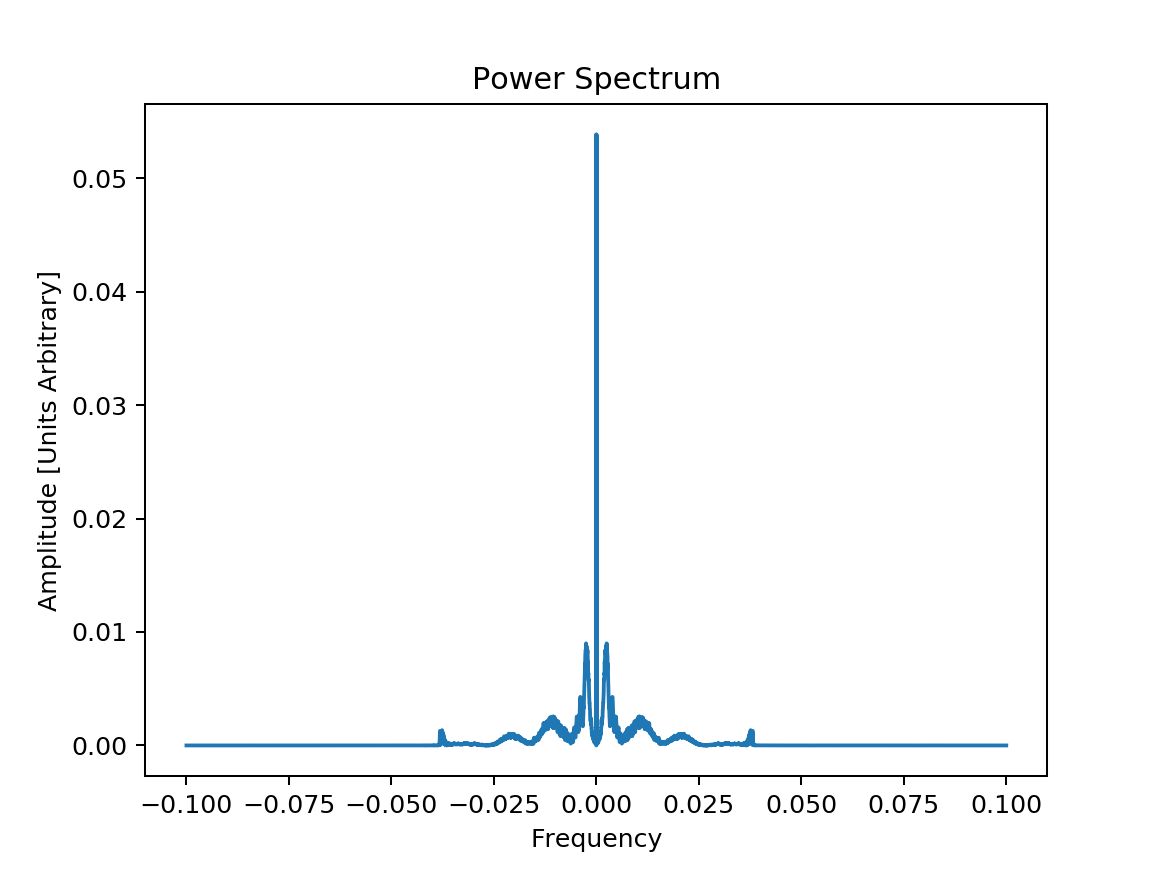

In [23]:
voltage_spectrum = np.fft.fft(sun_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly
plt.show()

<IPython.core.display.Javascript object>


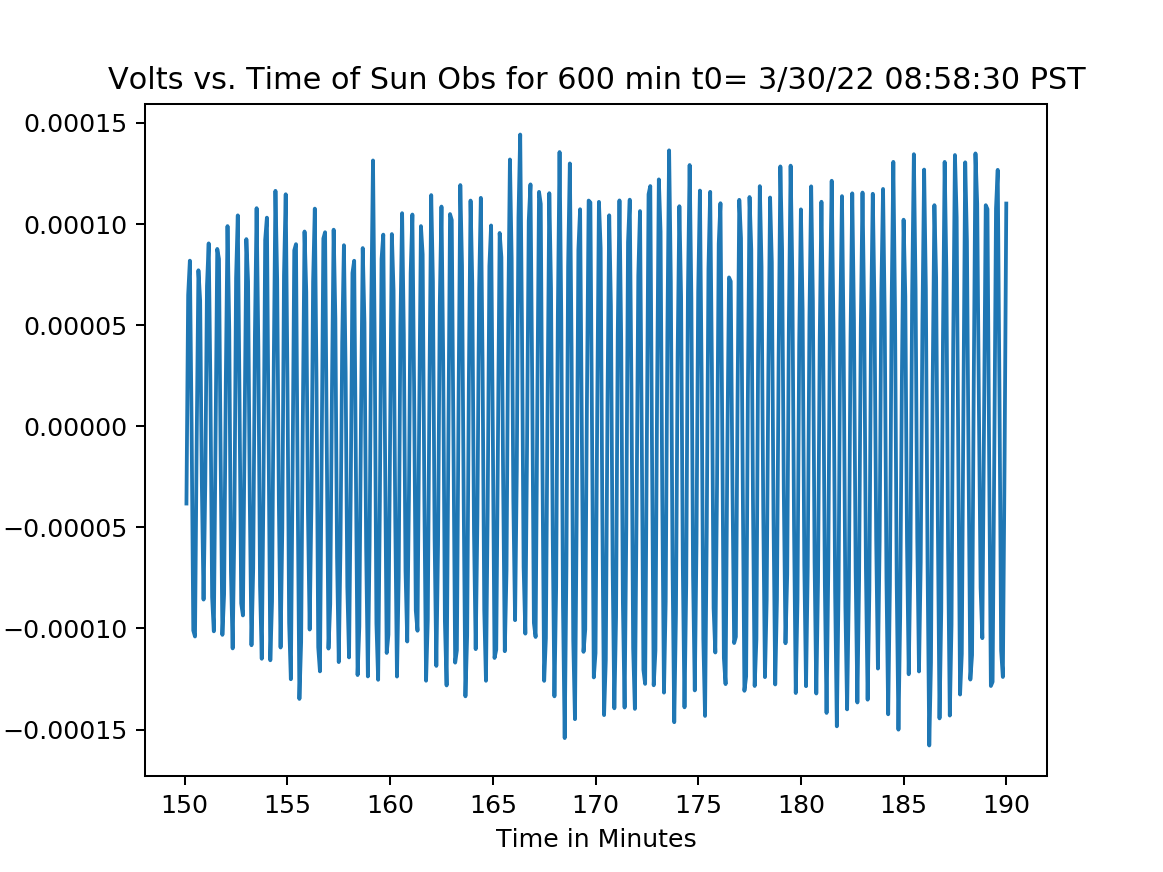

In [33]:
#cond = (sun_times/60 > 150) & (sun_times/60 < 200)
cond = (sun_times/60 > 150) & (sun_times/60 < 190)

plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times[cond]/60, sun_volts[cond])
plt.show()

<IPython.core.display.Javascript object>


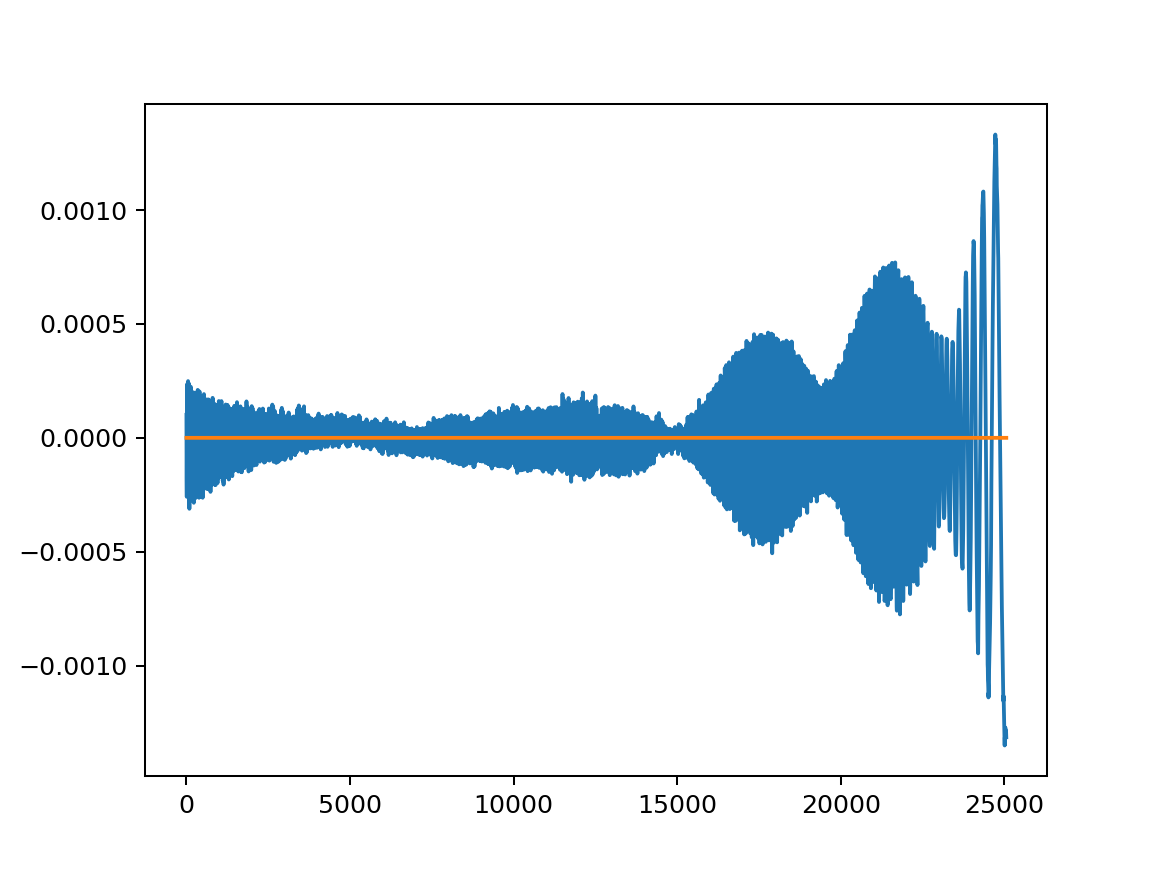

In [112]:
plt.figure()
plt.plot(sun_times, sun_volts)
p= np.polyfit(sun_times, sun_volts, 3)
fit = np.polyval(p, sun_times)
sun_volts-=fit
plt.plot(sun_times, fit)
plt.show()

In [34]:
RA = []
Dec = []
LST = []
for i in range(len(sun_times)):
    t_sun, tj_sun = utc_to_local(sun_times[i])
    RA_deg, dec = ugradio.coord.sunpos(tj_sun)
    precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
    RA.append(np.radians(precess_ra))
    Dec.append(np.radians(precess_dec))
    LST.append(ugradio.timing.lst(tj_sun))
    

#RA_deg, dec= ugradio.coord.sunpos() # wants julian date and it will return the RA and Dec
#print(RA_deg, "RA in degrees")
#arc_dec= 10.6/60 #converting arc min to degrees 
#arc_dec
#dec = -16 - arc_dec
#print(dec, "Dec in degrees")

#precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
#print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
#RA = np.radians(precess_ra)
#Dec = np.radians(precess_dec)
#print("RA is", RA, "Dec", Dec )

In [164]:
sun_data = pd.DataFrame({'RA': RA, 'Dec': Dec, 'LST':LST})
sun_data.to_csv('UpdatedSunCoords.csv')

In [9]:
print(lst)

      Unnamed: 0     sun_times  sun_volts
0              0      0.000000  -0.000263
1              1      4.963109  -0.000458
2              2      9.963097  -0.000502
3              3     14.963079  -0.000727
4              4     19.962893  -0.000889
...          ...           ...        ...
7108        7108  35539.963136  -0.001297
7109        7109  35544.963156  -0.001327
7110        7110  35549.963081  -0.001318
7111        7111  35554.963113  -0.001309
7112        7112  35559.963117  -0.001330

[7113 rows x 3 columns]


In [35]:
# guessing values for nu tau g to fit for the fringe amplitude

#guesses in meters
Bew = 20*u.m
Bns = 0*u.m
L = ugradio.nch.lat # latitude
wl = (c.c/(1.42*u.GHz)).to(u.m)  # wavelength in meters
# ntg = nu tao g
hs = RA*u.rad - LST*u.rad
ntg = ((Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs))
ntg_trunc = ntg[cond]
print(ntg_trunc.min(), ntg_trunc.max())

# now this needs to go into eq 12 (f is a function of A and B)

-86.98201844531745 -84.61874719272495


<IPython.core.display.Javascript object>


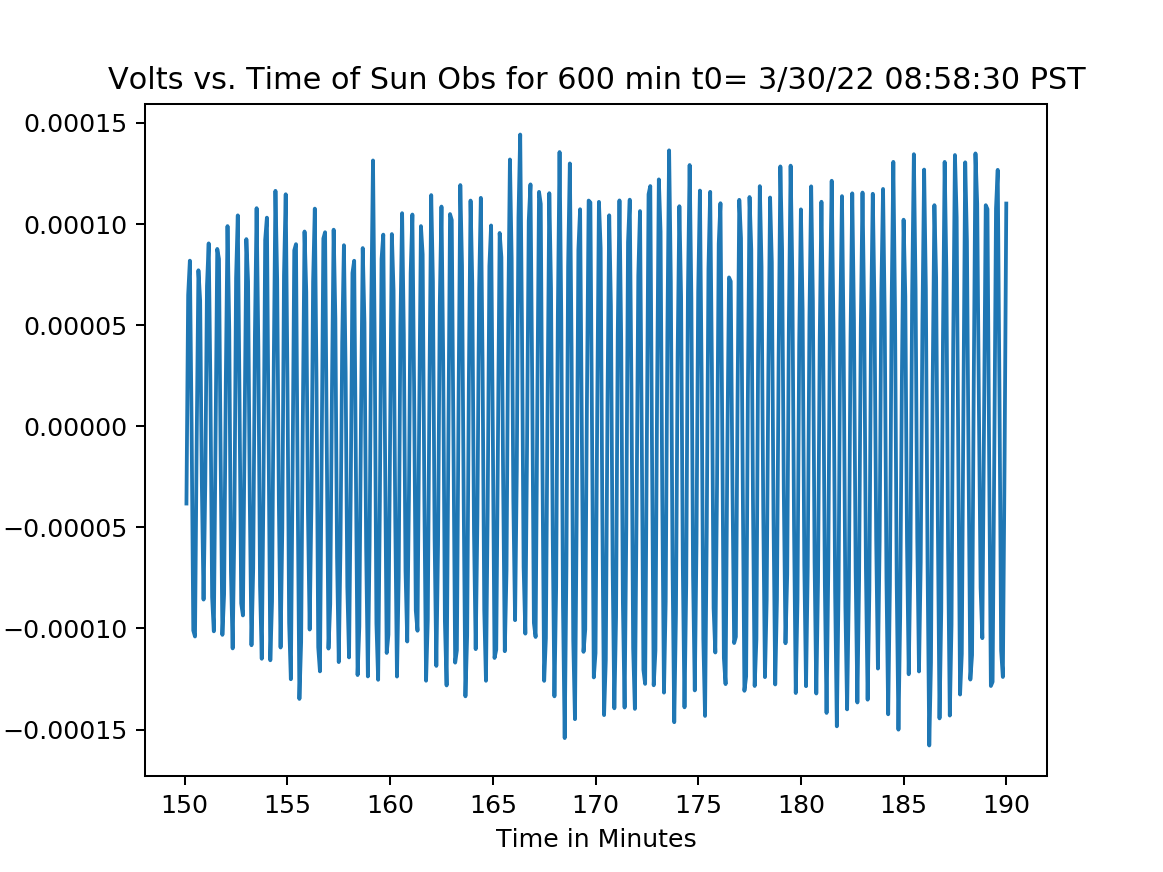

In [36]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times[cond]/60, sun_volts[cond])
plt.show()

In [37]:
F = sun_volts[cond]
def model(n,A,B):
    return A*np.cos(2*np.pi*u.rad*n) + B*np.sin(2*np.pi*u.rad*n) 
    
def chisq(n,A,B):
    stuff = model(n,A,B)
    return np.sum((stuff-F)**2)

popt, pcov = scipy.optimize.curve_fit(model, ntg_trunc, F)
A, B = popt
print(A, B, pcov)

-1.841779209206507e-06 -2.1828293557641766e-06 [[ 3.32950155e-11 -2.24253371e-12]
 [-2.24253371e-12  3.16237824e-11]]


In [38]:
ntg_smooth = np.linspace(ntg_trunc.min(), ntg_trunc.max(), len(ntg_trunc)*5)

<IPython.core.display.Javascript object>


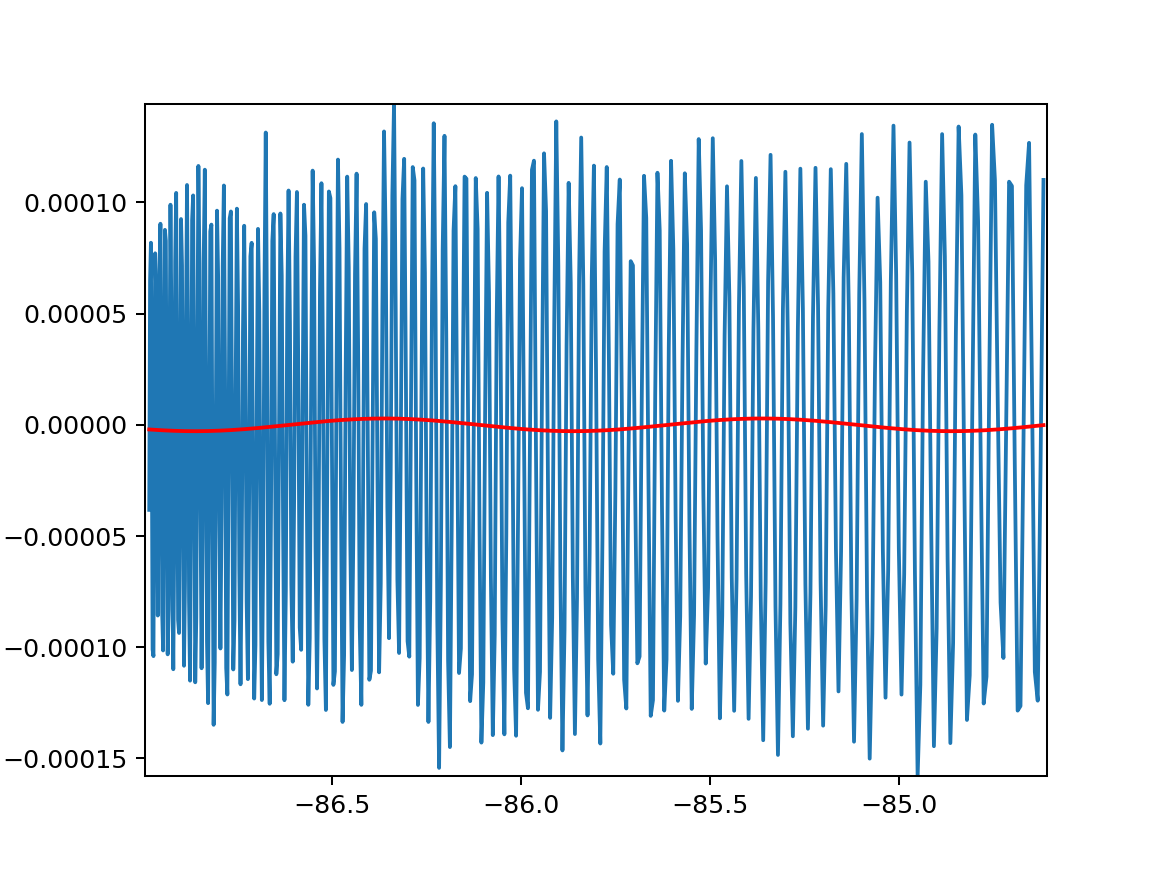

In [39]:
plt.figure()
plt.plot(ntg_trunc, F)
plt.plot(ntg_smooth, model(ntg_smooth, A, B), color='r')
plt.xlim(ntg_trunc.min()-0.01, ntg_trunc.max()+0.01)
plt.ylim(F.min(), F.max())
plt.show()

In [103]:
#guesses in meters
Bew_array = np.linspace(13,17,50)*u.m
Bns_array = np.linspace(1.5,5,50)*u.m
chisq_array = np.empty((50,50))
i = 0
j = 0

for Bew in Bew_array:
    for Bns in Bns_array:
        ntg = (Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs)
        ntg_trunc = ntg[cond]

        popt, pcov = scipy.optimize.curve_fit(model,ntg_trunc,F)
        A,B=popt
        #print(i, j)
        chisq_array[i,j] = chisq(ntg_trunc,A,B)
        j+=1
    i+=1
    j=0

In [104]:
print(A,B)

-1.8653191248584953e-06 1.8250319760195098e-06


<IPython.core.display.Javascript object>


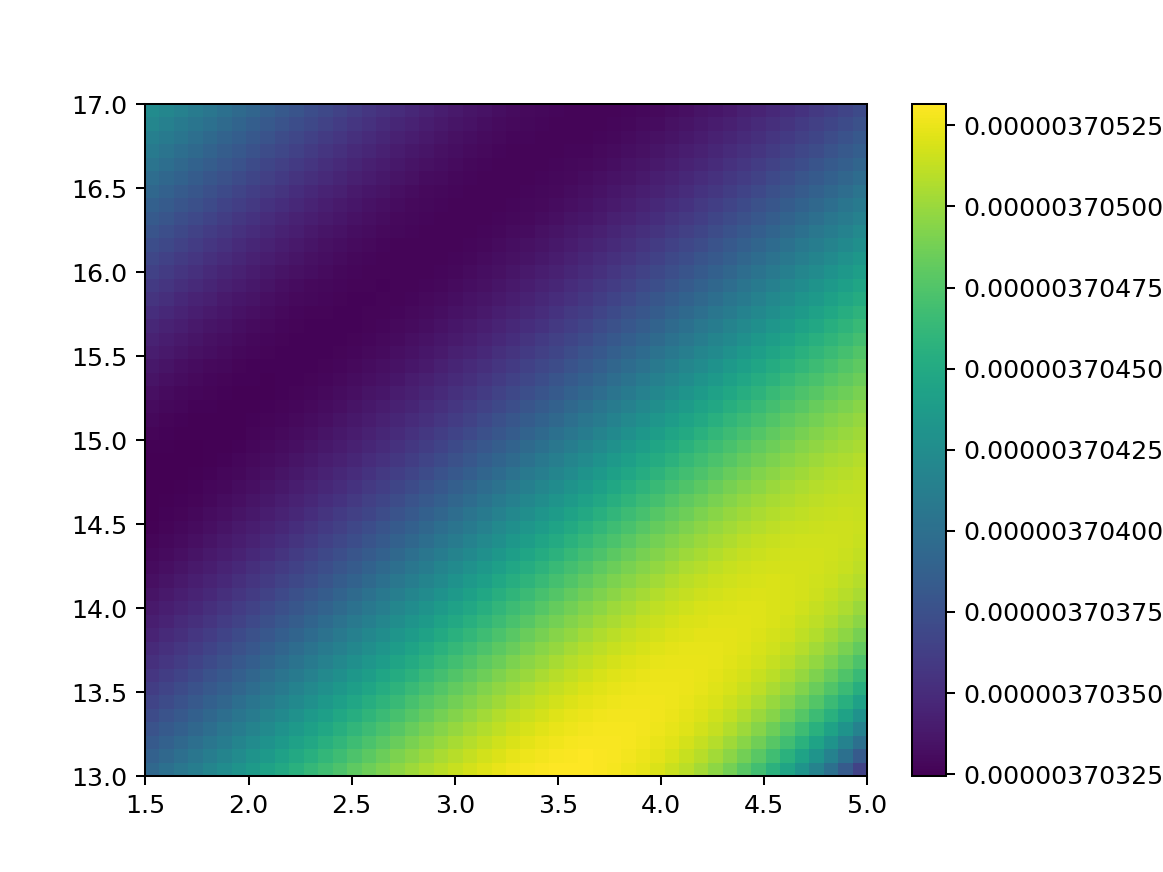

In [105]:
plt.figure()
plt.imshow(chisq_array,extent = [Bns_array.value.min(),Bns_array.value.max(),Bew_array.value.min(),Bew_array.value.max()], 
           aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [106]:
np.argmin(chisq_array)

1050

In [82]:
chisq_array.shape

(50, 50)

In [107]:
np.unravel_index(1050,(50,50))

(21, 0)

In [108]:
chisq_array[21,0]

3.703244401858612e-06

In [109]:
Bew_array[21],Bns_array[0]

(<Quantity 14.71428571 m>, <Quantity 1.5 m>)

In [110]:
scipy.special.j1(sun_volts)

array([ 5.05882759e-05, -8.94618322e-05, -1.29511881e-04, ...,
       -6.51538694e-04, -6.47040860e-04, -6.57543057e-04])

In [130]:
hs = np.where(hs<0,hs + 2*np.pi*u.rad,hs)

In [148]:
def bessel_model(ha,theta,A):
    u = Bew_array[21]*np.cos(Dec[0])*np.cos(ha)/wl
    x = 2*np.pi*theta*u
    return np.abs(A*scipy.special.j1(x)/x)

In [149]:
np.min(Dec)

-0.4018077673875504

In [151]:
par, cov = scipy.optimize.curve_fit(bessel_model,hs,np.abs(sun_volts),p0=[0.25*np.pi/180,.0005])

In [152]:
theta, A = par
bessel_fit = bessel_model(hs,theta,A)

In [170]:
#plt.figure()
#plt.plot(hs, np.abs(sun_volts))
#plt.plot(hs, bessel_fit)
#plt.show()

In [171]:
#attempt at fourier filtering below but it didn't go well :))))))))))

In [156]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr,dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr),dt))

In [162]:
fft = np.fft.fftshift(np.fft.fft(np.abs(sun_volts)))
freqs = freq(sun_volts, np.mean(np.diff(sun_volts)))
plt.plot(freqs,fft)
plt.ylim(-.1,.1)
plt.xlim(-0.1,0.1)
plt.show()